Main Changes: 
1) Architecture - VGG-like 
2) learning rate - 0.1 > 0.01 (Because #2 had issue seem like gradient exploding)
3) dataset normalize - 0.5 > reasonable values
4) removed useless reshape before train in CIFAR-10

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import sys
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 하이퍼파라미터 설정
exp_num = -1     # To save the result, change every time. -1 to not save.
num_epochs = 10
learning_rate = 0.01
dropout_prob = 0.5

if exp_num!=-1: os.mkdir(f'./Result{exp_num}')

In [3]:
# 가중치 드랍아웃 레이어
class WeightDropout(nn.Module):
    def __init__(self, module, p=0.5):
        super(WeightDropout, self).__init__()
        self.module = module
        self.p = p
        self.weight = nn.Parameter(module.weight.data)

    def forward(self, *args):
        if self.training:
            # dropout을 적용한 가중치
            weight = F.dropout(self.weight, p=self.p, training=True)
            # self.module.weight에 새로운 가중치 할당
            self.module.weight = nn.Parameter(weight)
        return self.module(*args)

# ***Basic Code***

In [4]:
def dataset_MNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader


def dataset_CIFAR10():
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
  ])
  train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
  return train_loader, test_loader

In [5]:
# 모델 학습 함수
def Run(num_epochs, dataset, method):
  if dataset=='MNIST': train_loader, test_loader = dataset_MNIST()
  elif dataset=='CIFAR-10': train_loader, test_loader = dataset_CIFAR10()

  # Save log
  if exp_num!=-1:
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'w')
    sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'a')

  model.to(device)
  train_acc_list = []
  test_acc_list = []
  train_loss_list = []
  test_loss_list = []
  
  for epoch in range(num_epochs):
      # Train
      model.train()
      train_loss, train_correct = 0, 0
      for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
      train_loss /= len(train_loader.dataset)
      train_accuracy = train_correct / len(train_loader.dataset)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      # Test
      model.eval()
      test_loss, test_correct = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
          test_loss /= len(test_loader.dataset)
          test_accuracy = test_correct / len(test_loader.dataset)
          test_acc_list.append(test_accuracy)
          test_loss_list.append(test_loss)

      # Show Result
      print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.8f} | Train Accuracy: {round(train_accuracy*100, 2):.6f} | '
            f'Test Loss: {test_loss:.8f} | Test Accuracy: {round(test_accuracy*100, 2):.6f}')

  return train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [6]:
# 그래프
def plot(dataset, method, exp_num):
    figname = f"[{dataset}] {method}  #{exp_num}.png"
    plt.figure(figsize=(10, 6), dpi=1000)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if exp_num != -1 : plt.savefig(f'./Result{exp_num}/'+figname)
    plt.show()

# ***Experiments***

## 1) [MNIST] VGG-like without Dropout

In [7]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'NoDrop')

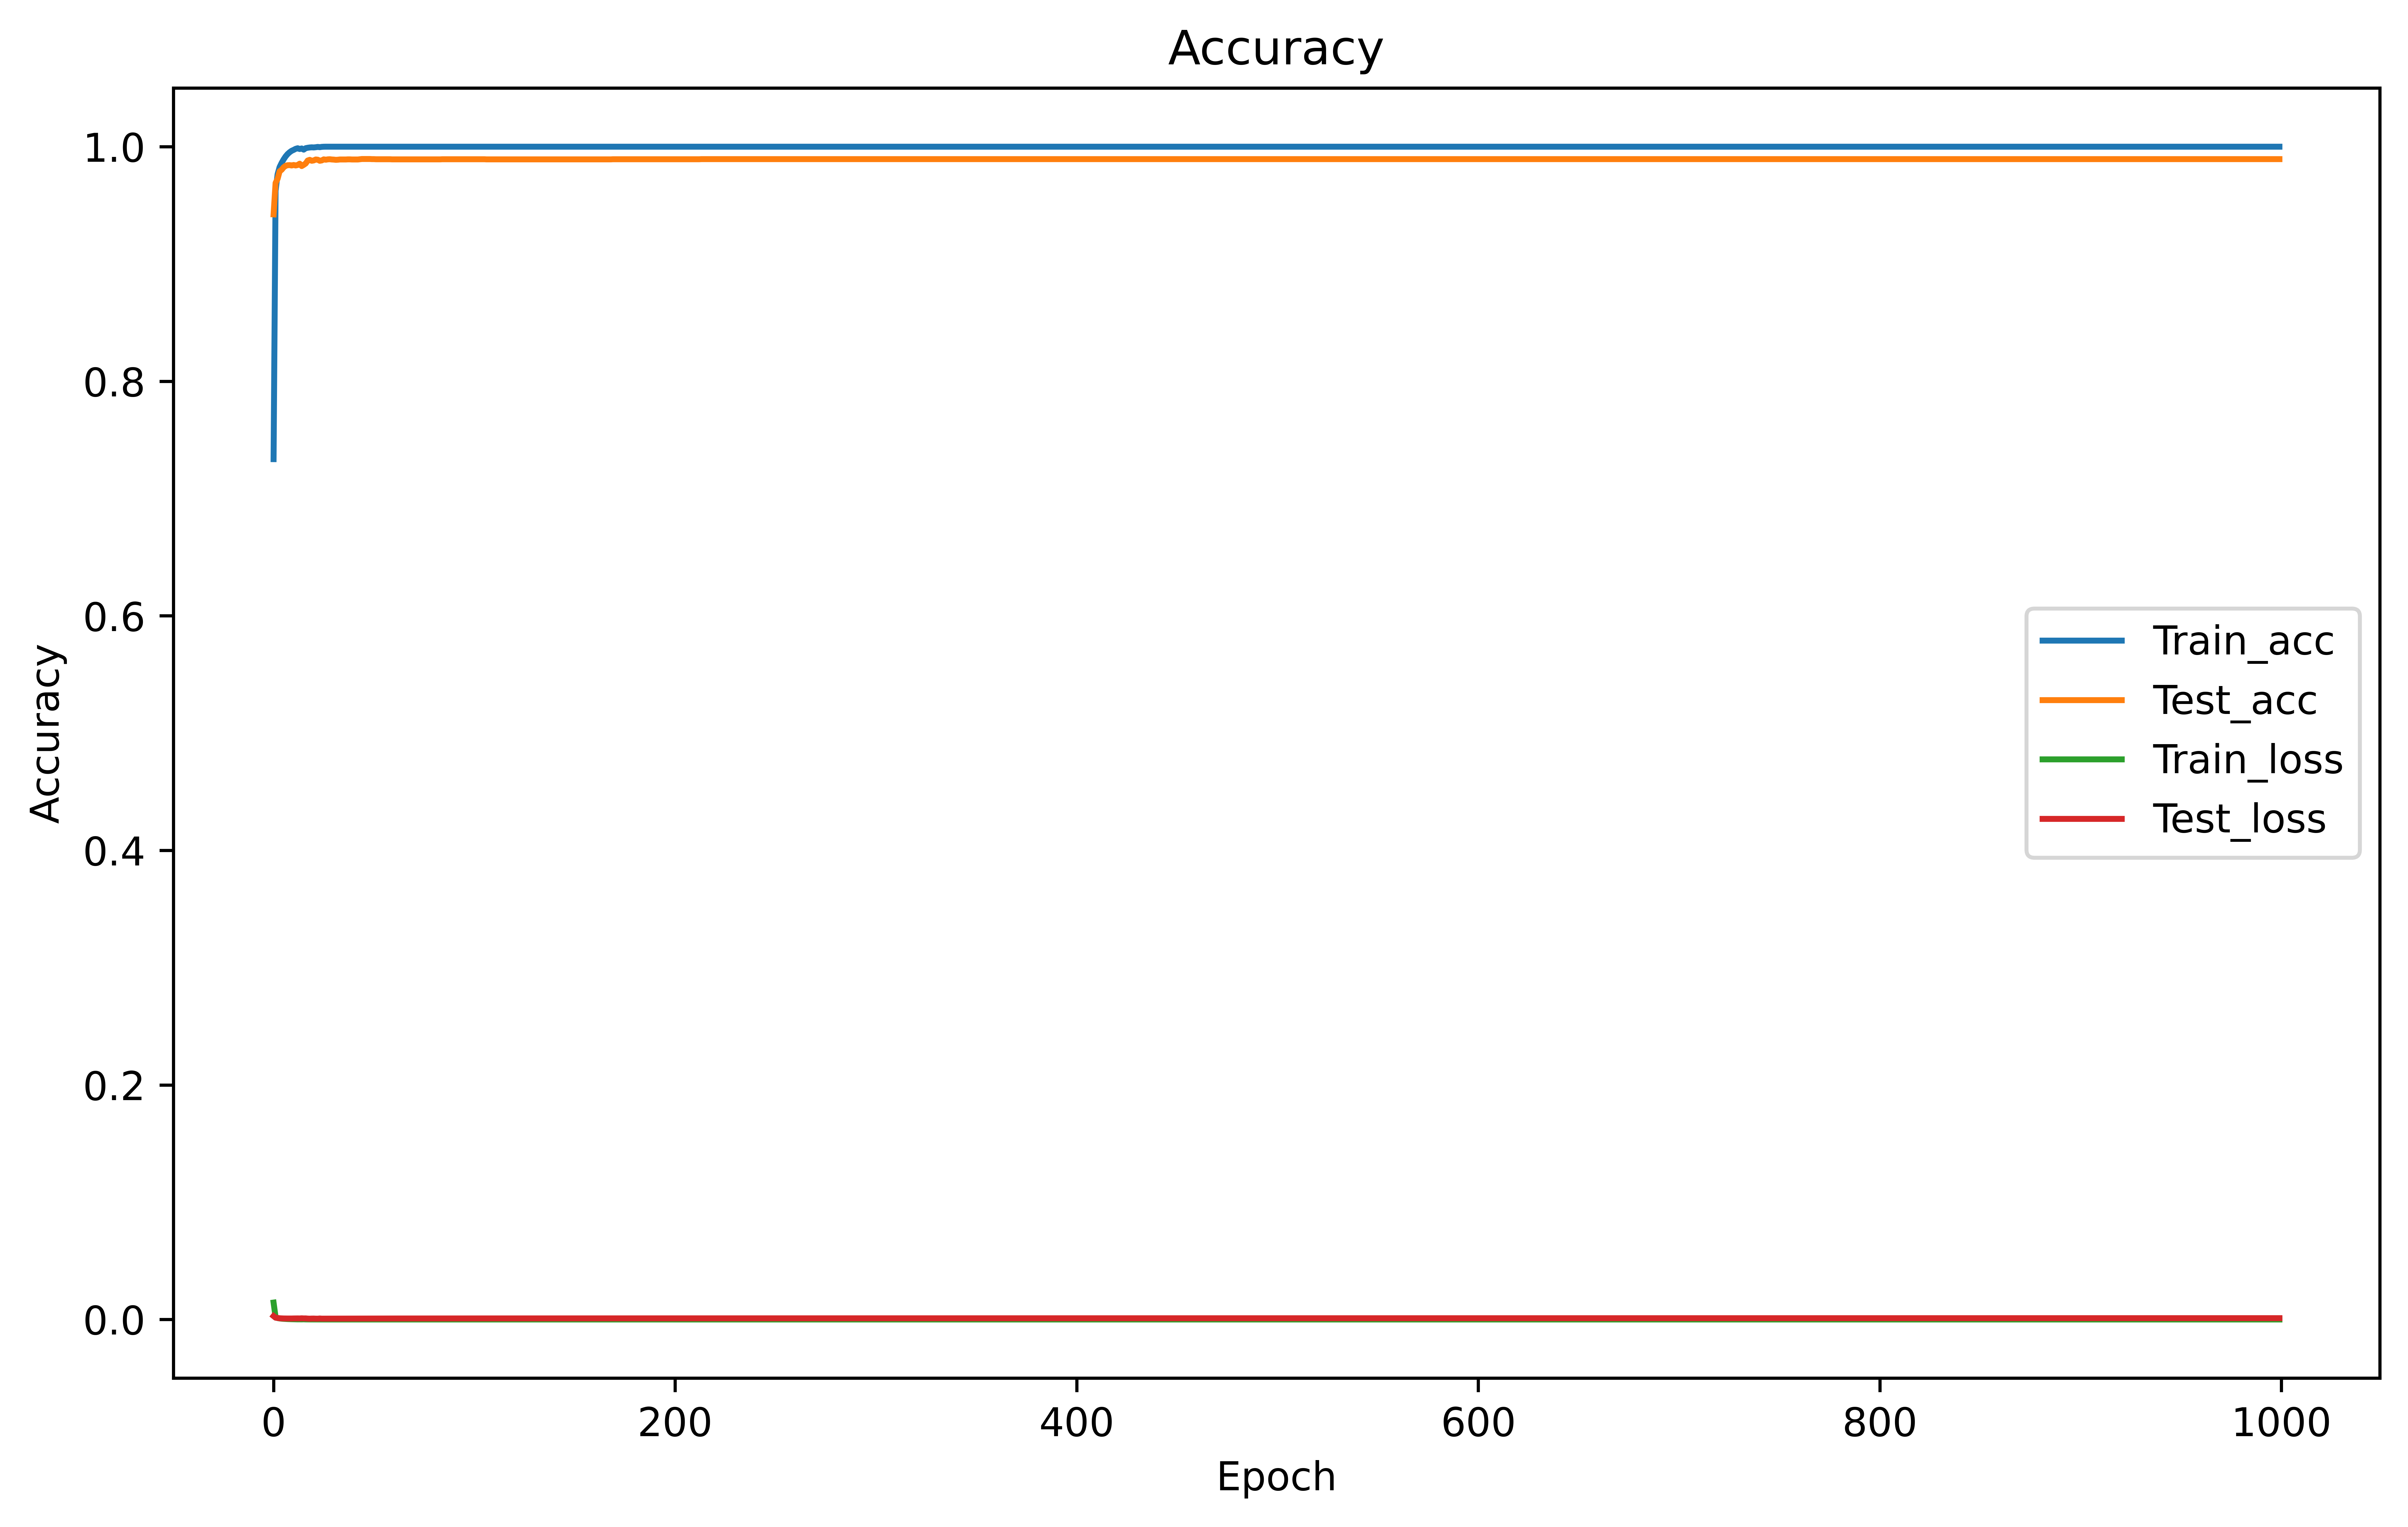

In [ ]:
plot('MNIST', 'NoDrop', exp_num)

## 2) [MNIST] VGG-like with Dropout

In [ ]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'Drop')

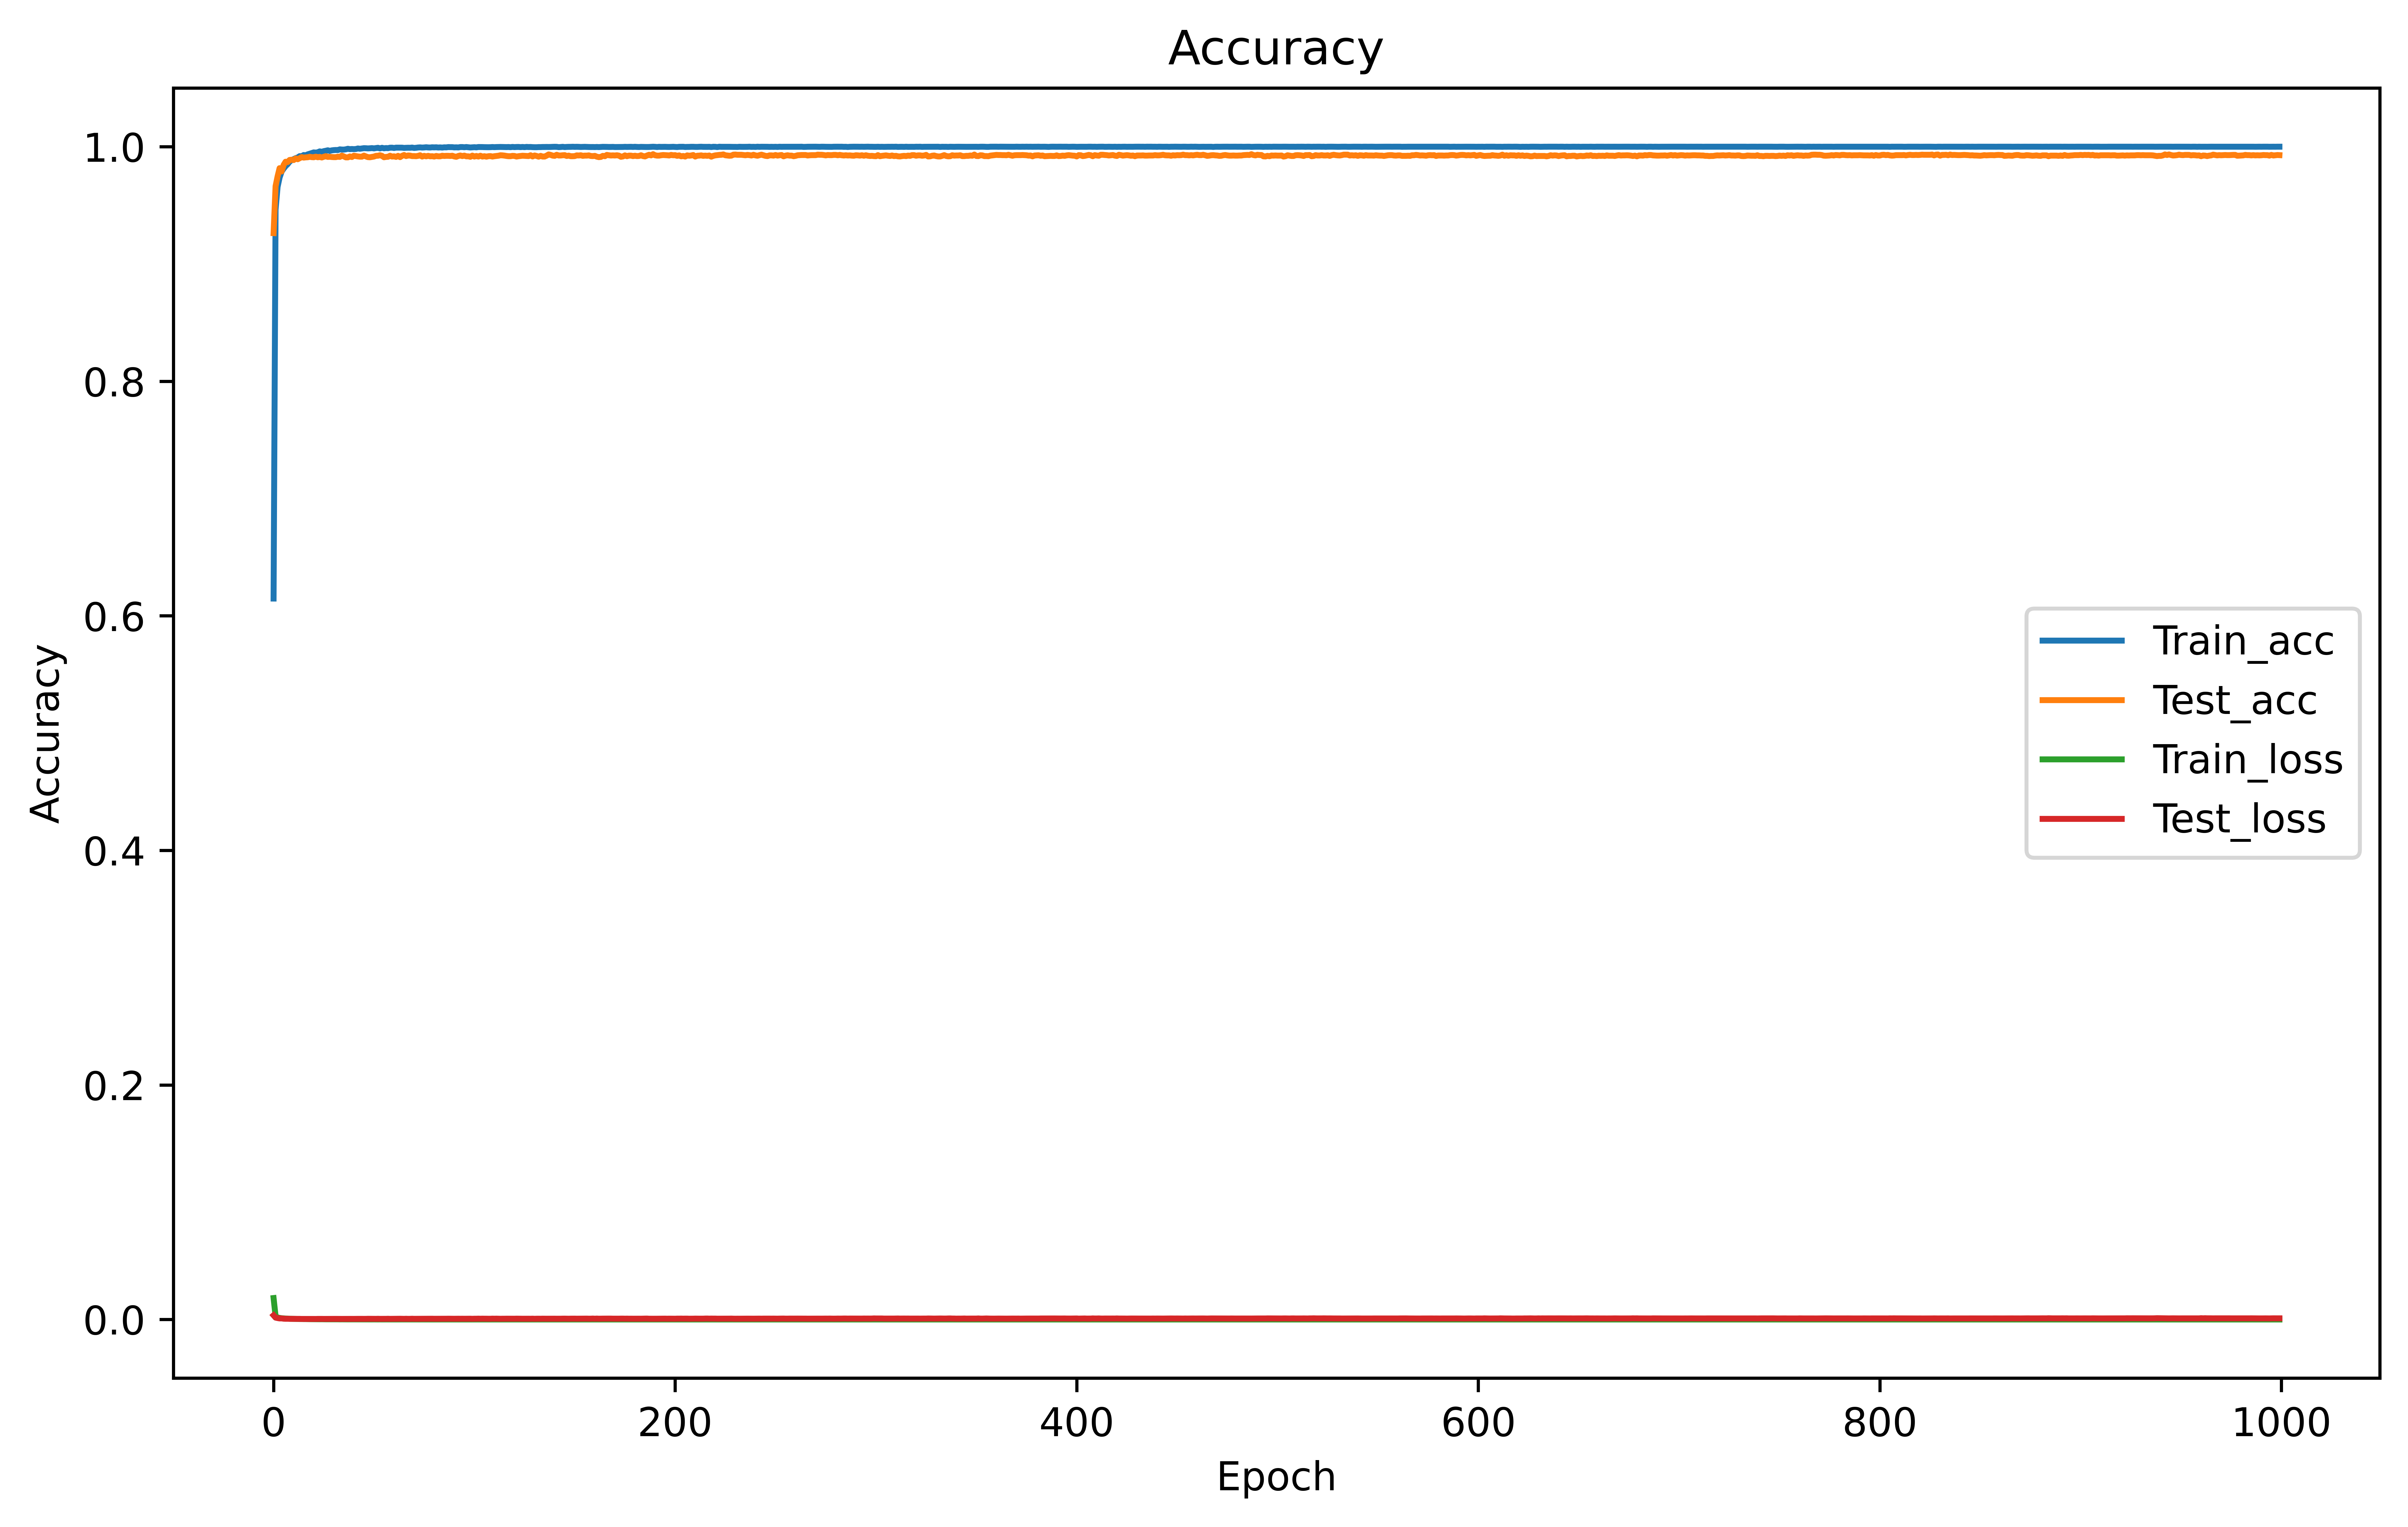

In [ ]:
plot('MNIST', 'Drop', exp_num)

## 3) [MNIST] VGG-like with Weight Dropout

In [ ]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(4*4*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# 모델 초기화
model = Net_MNIST()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'MNIST', 'WeightDrop')

KeyboardInterrupt: 

In [ ]:
plot('MNIST', 'WD', exp_num)

NameError: name 'train_acc_list' is not defined

<Figure size 10000x6000 with 0 Axes>

## 1) [CIFAR-10] VGG16-like without Dropout

In [ ]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'NoDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.0306 | Train Accuracy: 27.25 | Test Loss: 0.0324 | Test Accuracy: 27.69
Epoch  2 | Train Loss: 0.0225 | Train Accuracy: 47.82 | Test Loss: 0.0303 | Test Accuracy: 38.10
Epoch  3 | Train Loss: 0.0181 | Train Accuracy: 59.16 | Test Loss: 0.0224 | Test Accuracy: 52.98
Epoch  4 | Train Loss: 0.0146 | Train Accuracy: 67.22 | Test Loss: 0.0173 | Test Accuracy: 62.58
Epoch  5 | Train Loss: 0.0120 | Train Accuracy: 73.04 | Test Loss: 0.0155 | Test Accuracy: 67.21
Epoch  6 | Train Loss: 0.0098 | Train Accuracy: 78.12 | Test Loss: 0.0123 | Test Accuracy: 74.14
Epoch  7 | Train Loss: 0.0079 | Train Accuracy: 82.36 | Test Loss: 0.0130 | Test Accuracy: 75.05
Epoch  8 | Train Loss: 0.0063 | Train Accuracy: 86.00 | Test Loss: 0.0142 | Test Accuracy: 73.45
Epoch  9 | Train Loss: 0.0049 | Train Accuracy: 89.05 | Test Loss: 0.0151 | Test Accuracy: 73.86
Epoch 10 | Train Loss: 0.0039 | Train Accuracy: 91.

KeyboardInterrupt: 

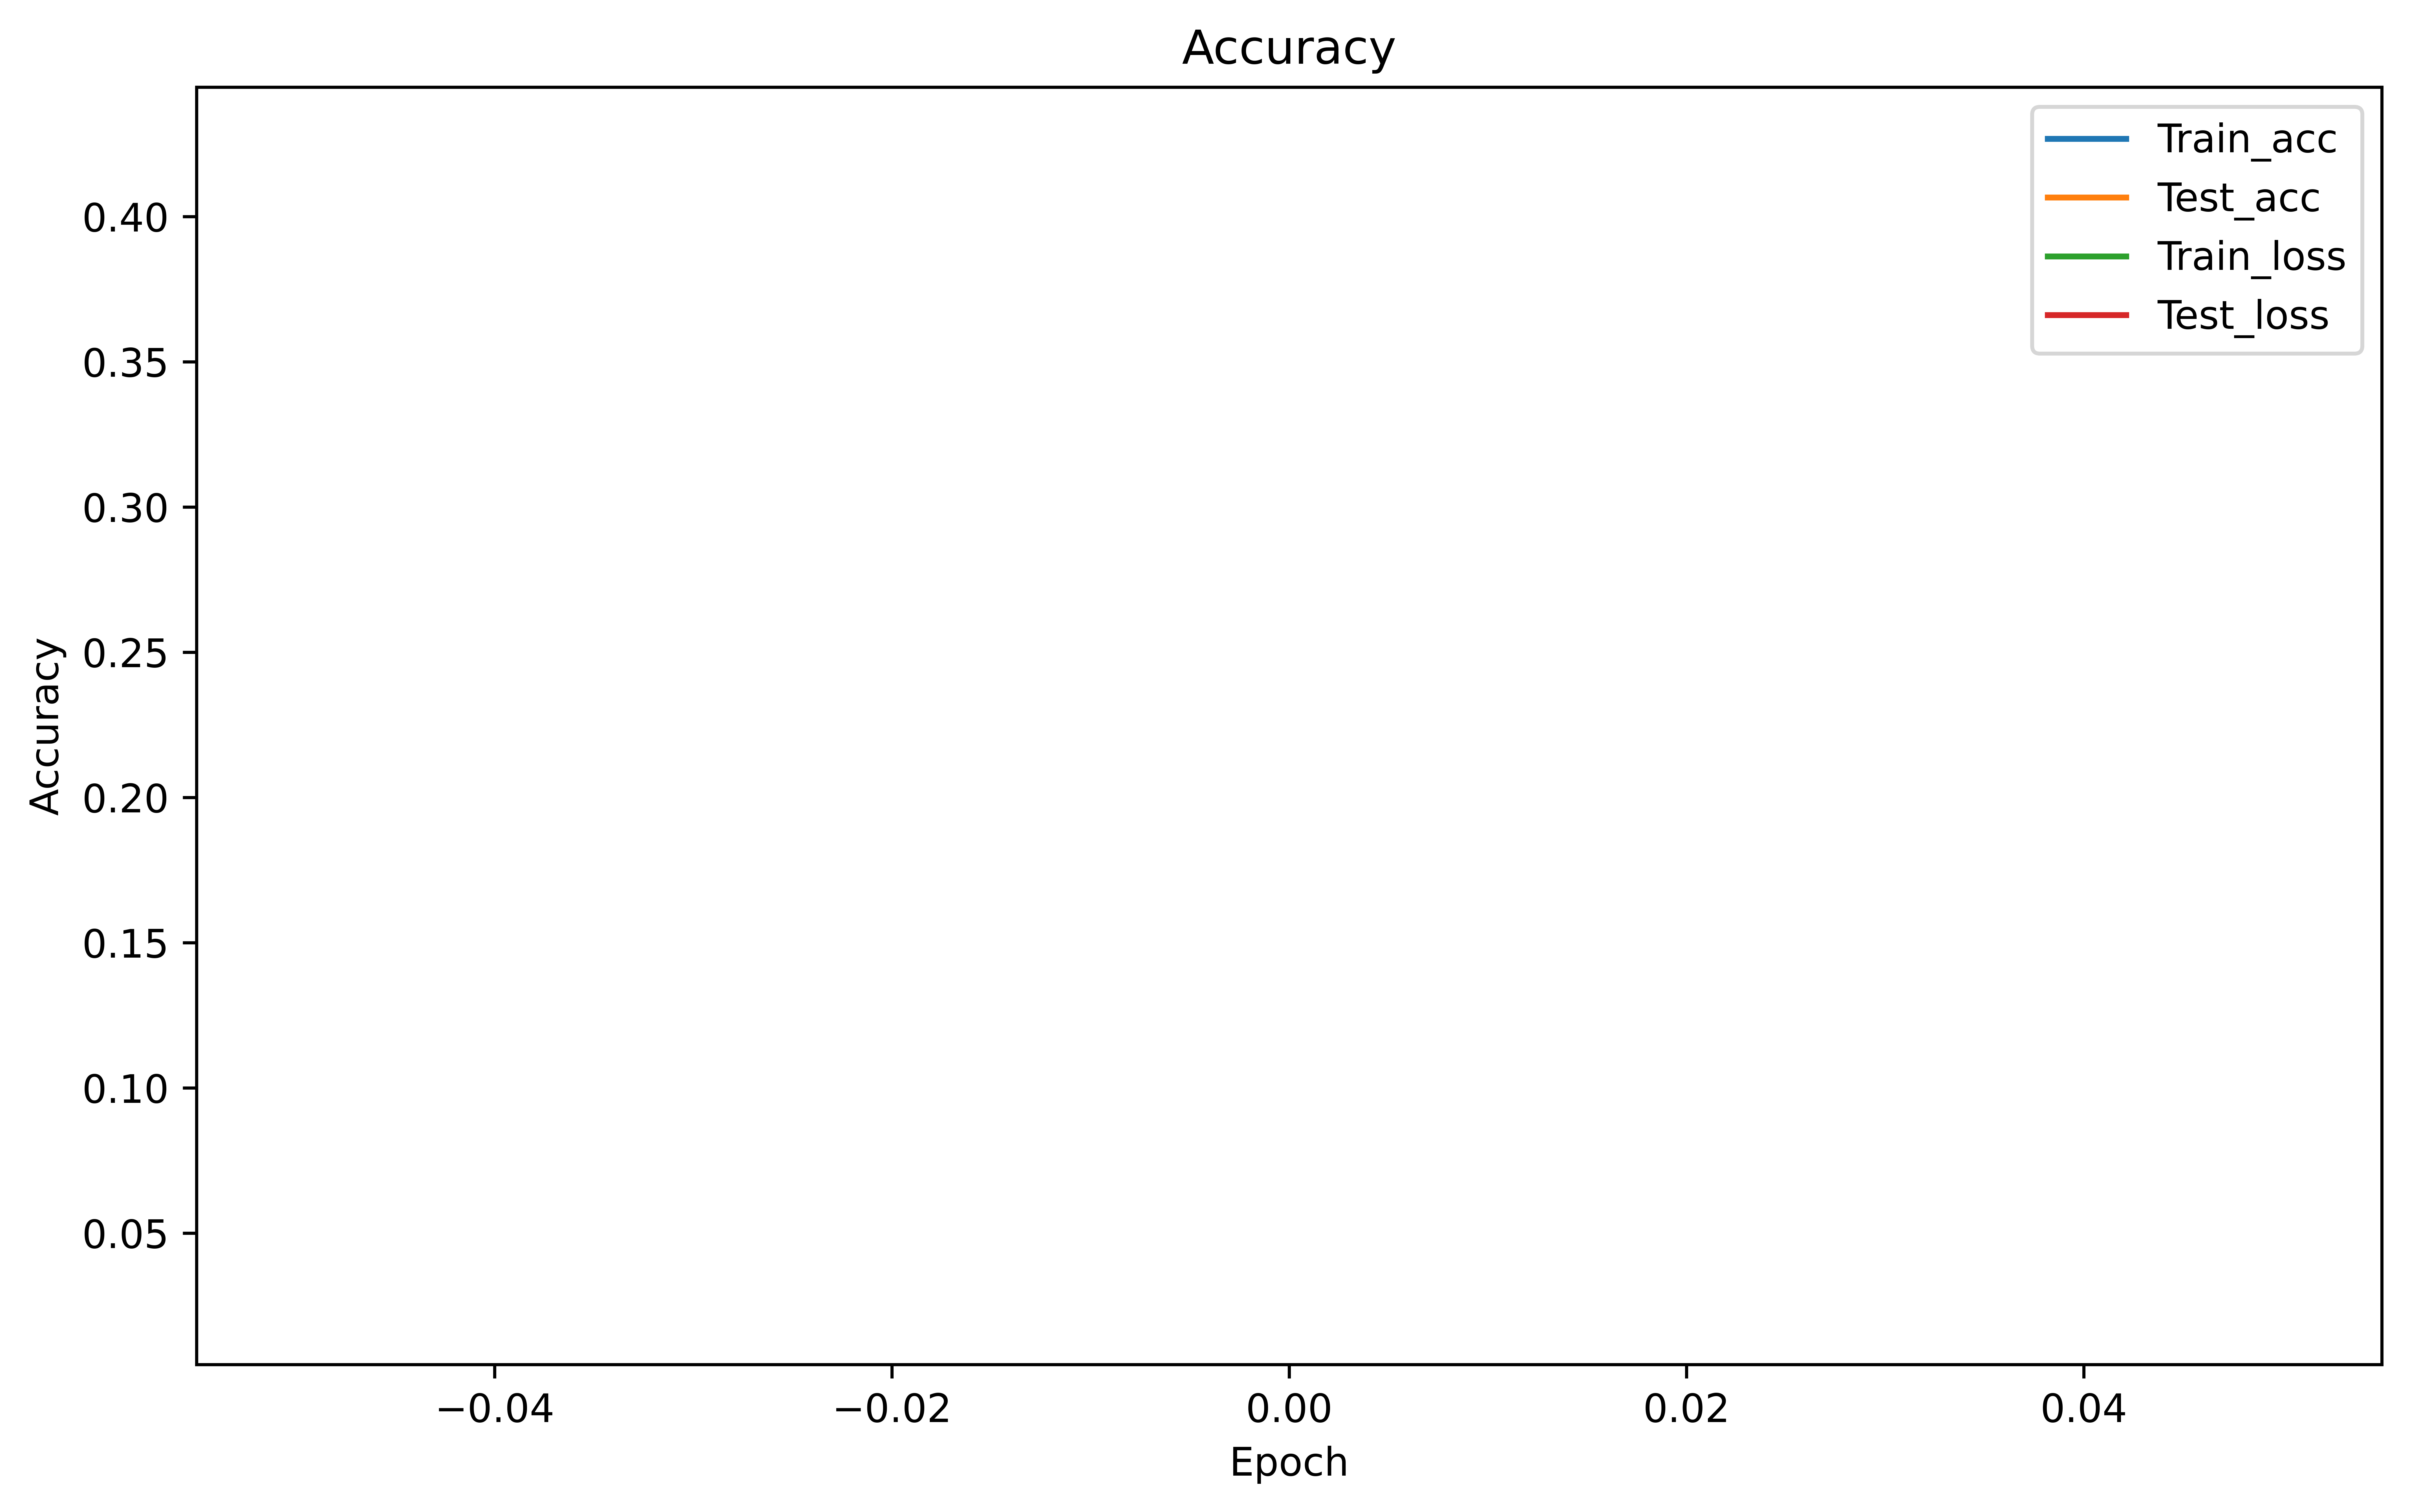

In [ ]:
plot('CIFAR10', 'NoDrop', exp_num)

## 2) [CIFAR-10] VGG-like with Dropout

In [ ]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.drop = nn.Dropout(dropout_prob)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'Drop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.0253 | Train Accuracy: 40.98 | Test Loss: 0.0277 | Test Accuracy: 39.37


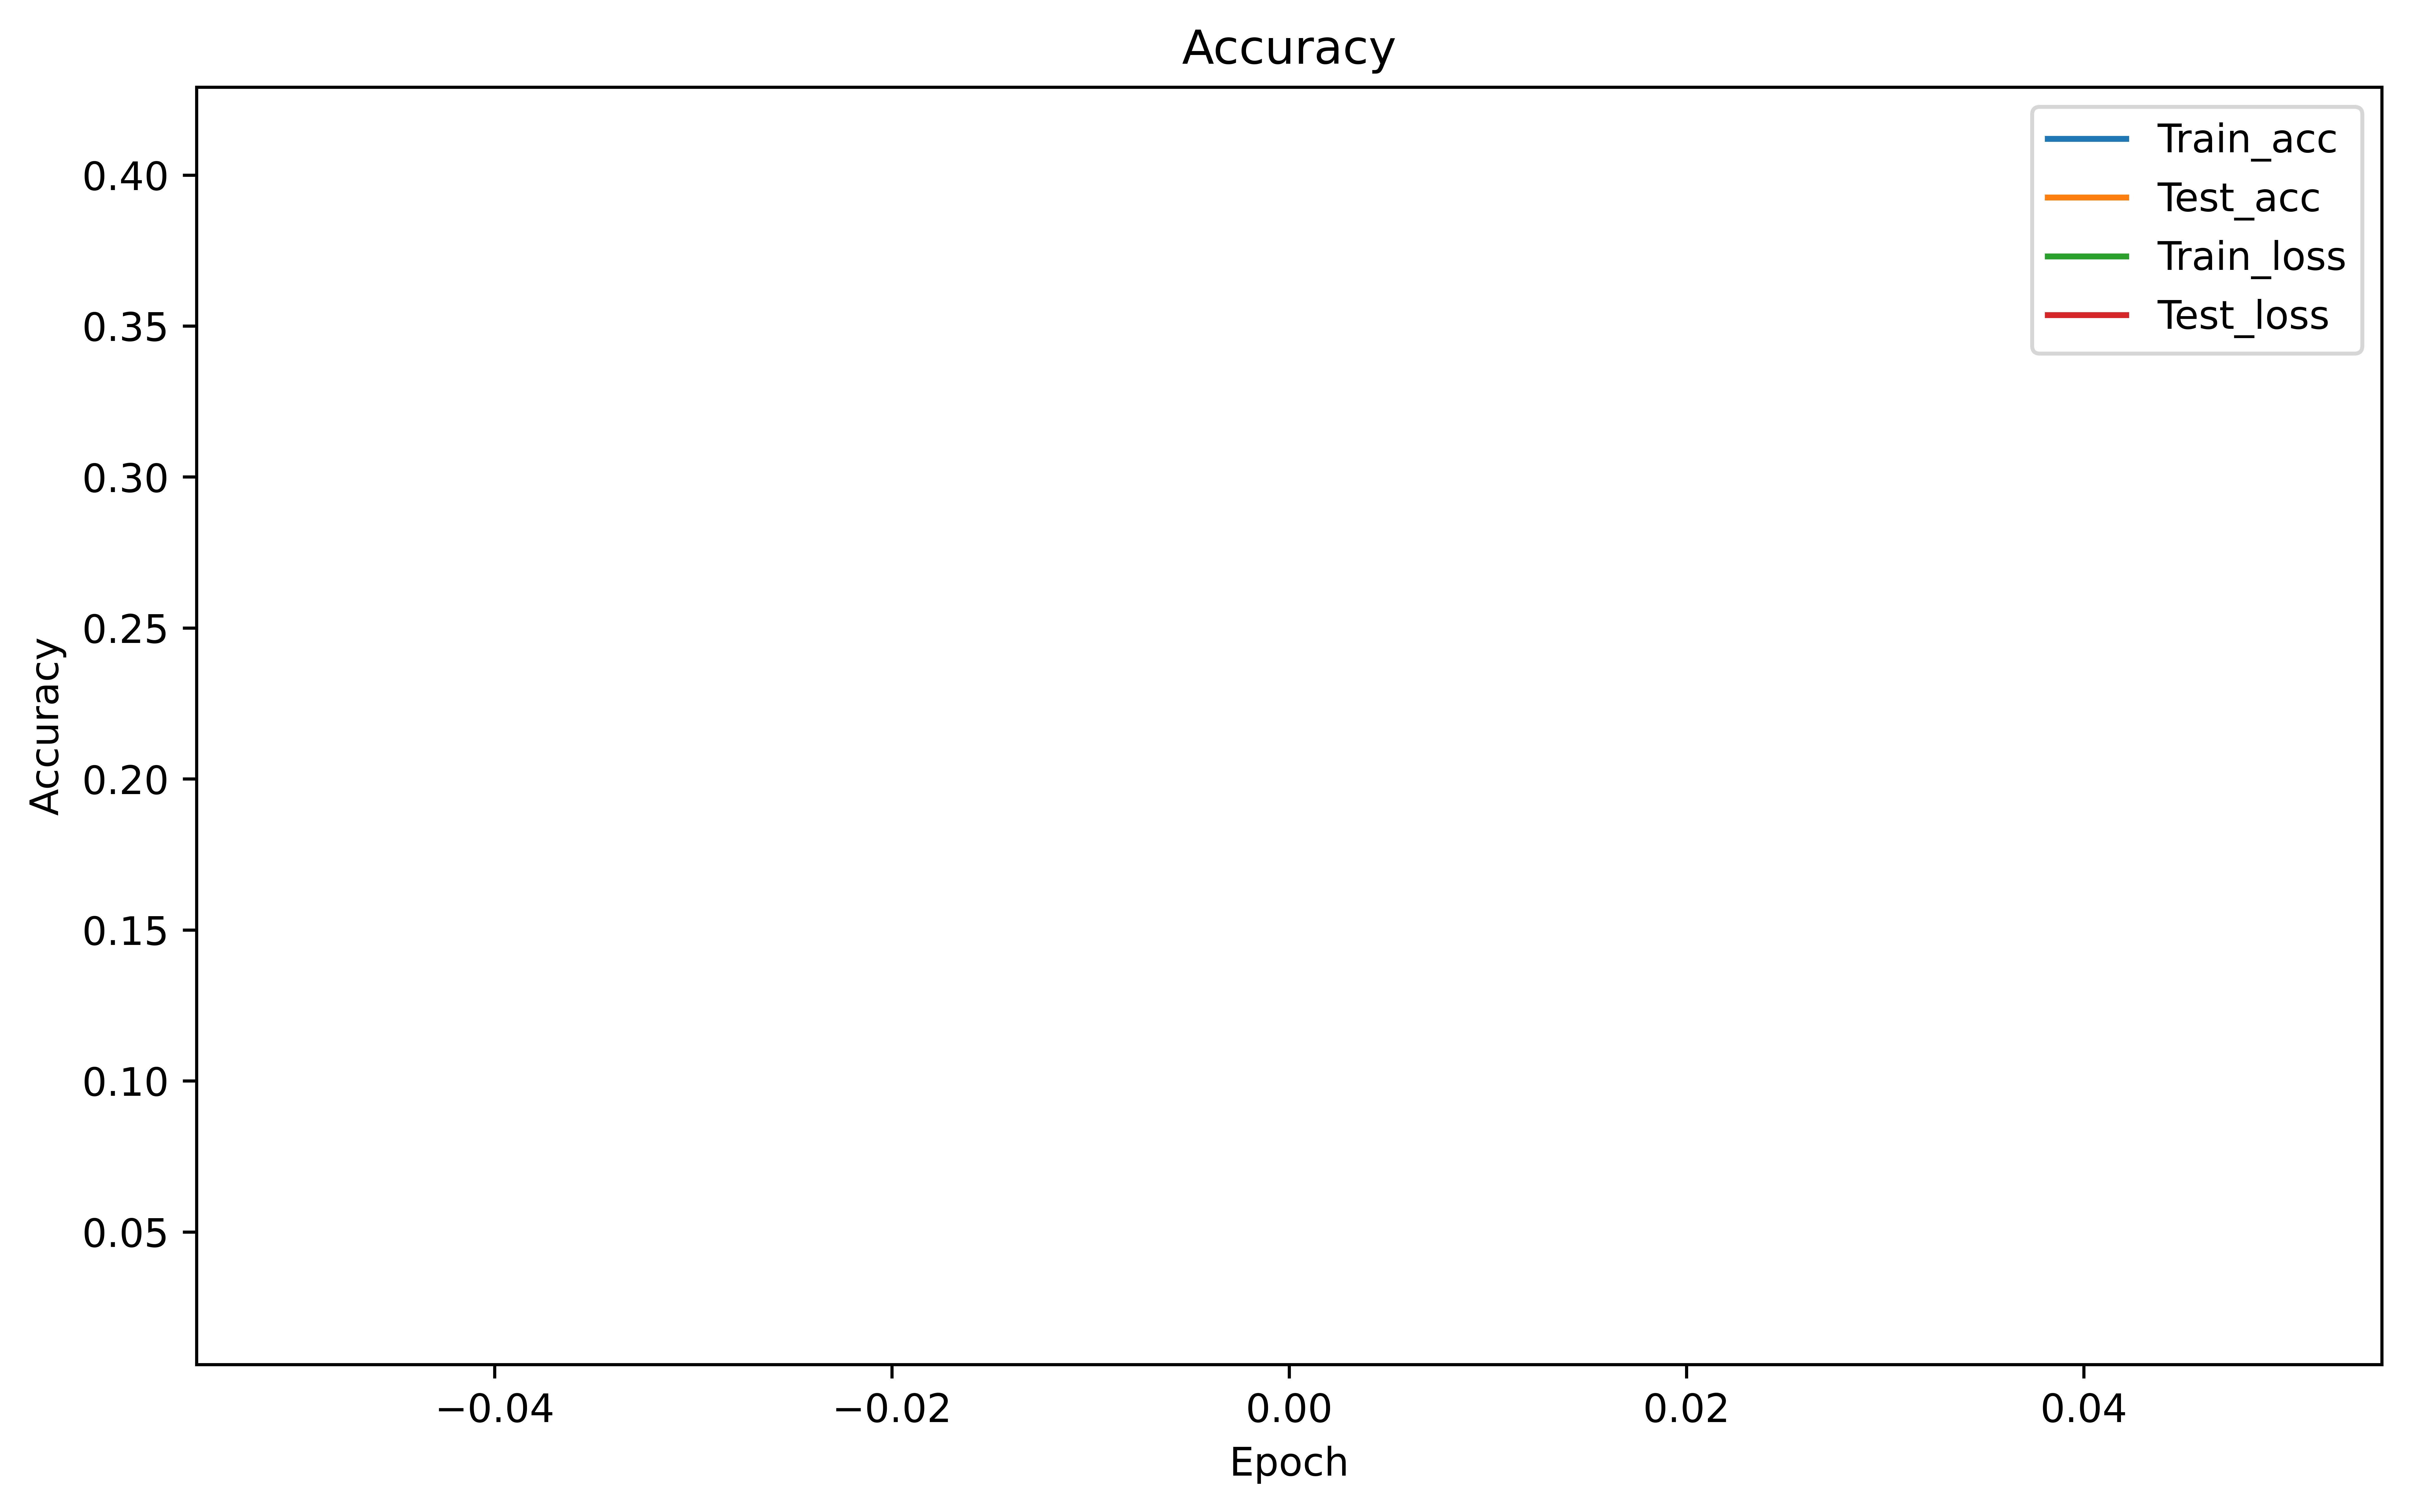

In [ ]:
plot('CIFAR10', 'Drop', exp_num)

## 3) [CIFAR-10] VGG-like Weight Dropout

In [ ]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = WeightDropout(nn.Linear(5*5*128, 4096), p=dropout_prob)
        self.fc2 = WeightDropout(nn.Linear(4096, 4096), p=dropout_prob)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 모델 초기화
model = Net_CIFAR10()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 모델 학습
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(num_epochs, 'CIFAR-10', 'WeightDrop')

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.0265 | Train Accuracy: 38.47 | Test Loss: 0.0279 | Test Accuracy: 36.35


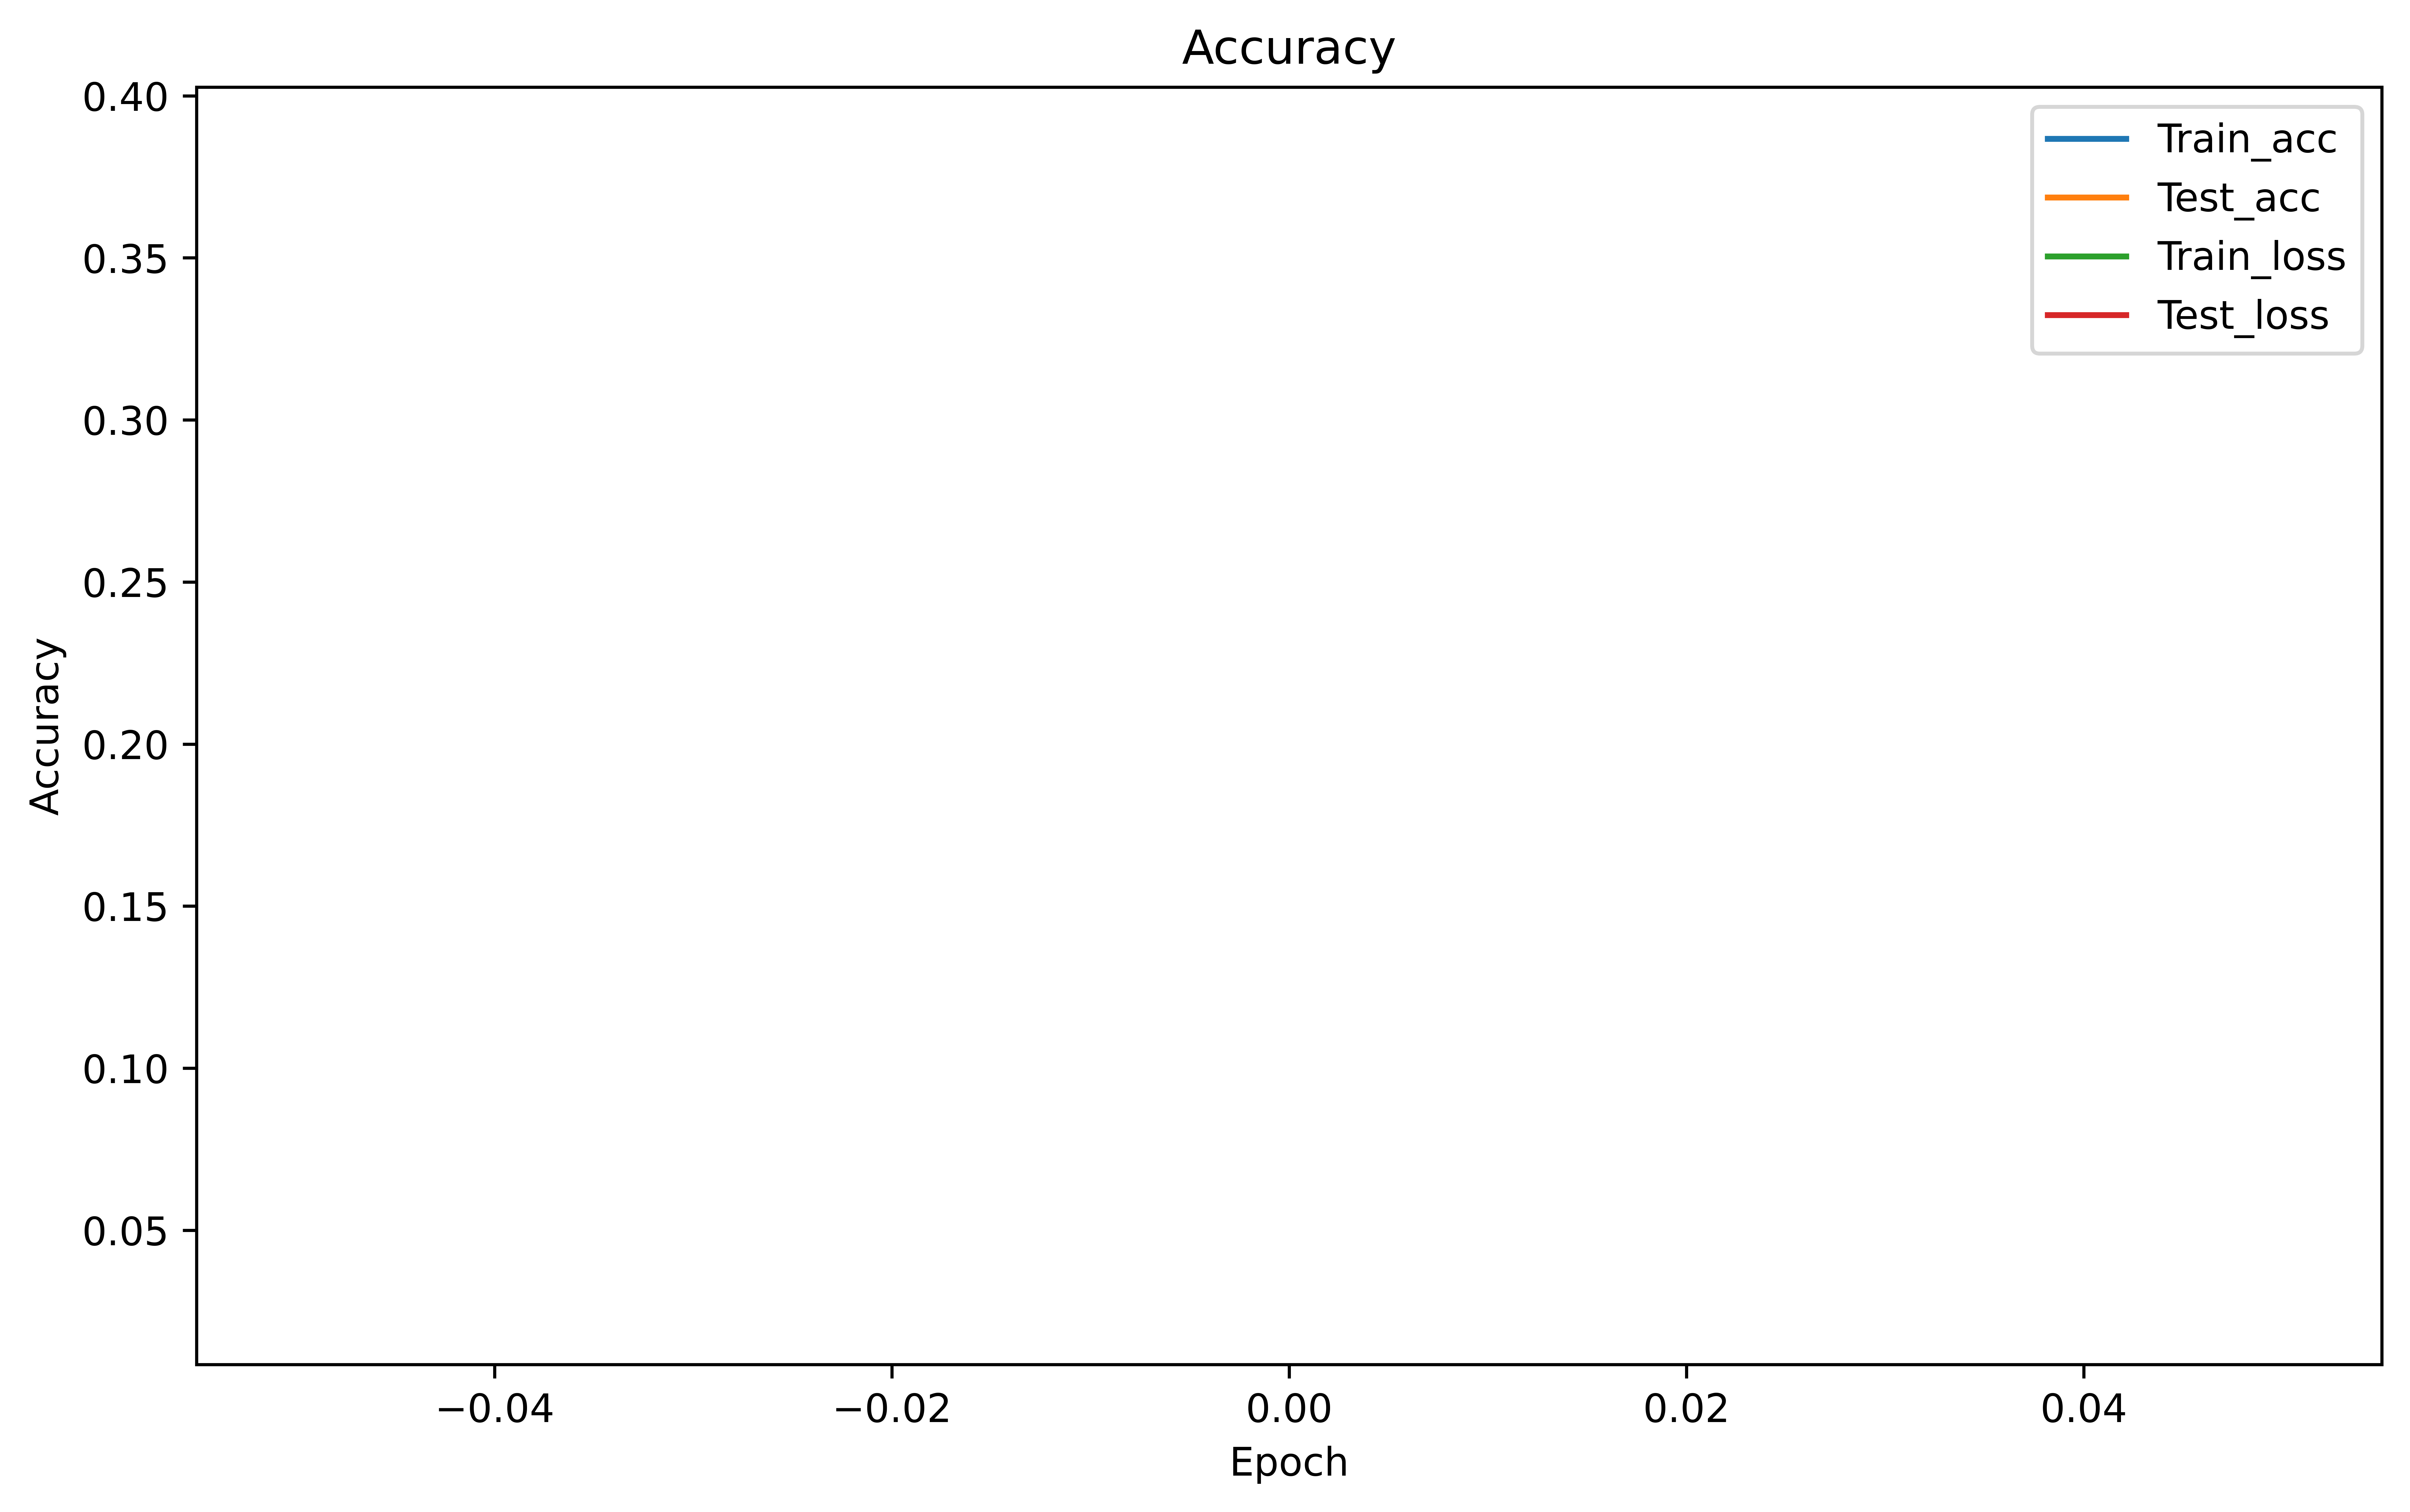

In [ ]:
plot('CIFAR10', 'WD', exp_num)